# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████████████████████████████████████████████████████| 60.0K/60.0K [01:02<00:00, 957File/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

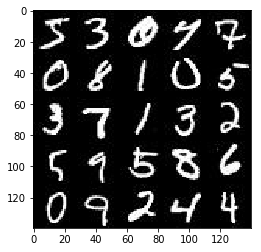

In [1]:
import helper
data_dir = './data'
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

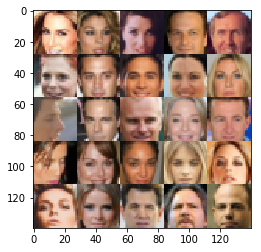

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    original = (image_width, image_height, image_channels)
    realInp = tf.placeholder(tf.float32, (None, *original), name='real_input')
    zInp = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, None, name='learning_rate')

    return (realInp, zInp, lr)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "C:\\Users\\lipec\\Miniconda3\\lib\\runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "C:\\Users\\lipec\\Miniconda3\\lib\\runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "C:\\Users\\lipec\\Miniconda3\\lib\\site-packages\\ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "C:\\Users\\lipec\\Miniconda3\\lib\\site-packages\\traitlets\\config\\application.py", line 658, in launch_instance\n    app.start()', 'File "C:\\Users\\lipec\\Miniconda3\\lib\\site-packages\\ipykernel\\kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "C:\\Users\\lipec\\Miniconda3\\lib\\site-packages\\zmq\\eventloop\\ioloop.py", li

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    keepProb = 0.95 # dropout - changed due to reviewer feedback
    leaky = lambda x: tf.maximum(0.15 * x, x) # fixed alpha
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        firstLayer = leaky (
            tf.layers.conv2d(
                images, 
                64, 
                3, 
                strides=2, 
                padding='same', 
                kernel_initializer=tf.contrib.layers.xavier_initializer()
            )
        )
        firstLayer = tf.layers.dropout(firstLayer, rate=keepProb)
        
        
        secondLayer = leaky(
            tf.layers.batch_normalization( 
                tf.layers.conv2d(
                    firstLayer, 
                    128, 
                    3, 
                    strides=2, 
                    padding='same',
                    kernel_initializer=tf.contrib.layers.xavier_initializer()
                ), 

                training = True
            )
        )
        secondLayer = tf.layers.dropout(secondLayer, rate=keepProb)

        thirdLayer = leaky( 
            tf.layers.batch_normalization( 
                tf.layers.conv2d(
                    secondLayer, 
                    256, 
                    3, 
                    strides=2,
                    padding='same', 
                    kernel_initializer=tf.contrib.layers.xavier_initializer()
                ), 
                training=True
            )
        )
        thirdLayer = tf.layers.dropout(thirdLayer, rate=keepProb)


        logits = tf.layers.dense(tf.reshape(thirdLayer, (-1, 4 * 4 * 256)), 1)
        out = tf.nn.sigmoid(logits)
        
    return (out, logits)



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    keepProb = 0.95 # dropout - changed due to reviewers feedback
    leaky = lambda x: tf.maximum(0.15 * x, x) # fixed alpha

    with tf.variable_scope('generator', reuse=not is_train):
        
        firstLayer = leaky(
            tf.layers.batch_normalization(
                tf.reshape(
                    tf.layers.dense(z, 7*7*512),
                    (-1, 7, 7, 256)
                ),
                training=is_train
            )
        )
        firstLayer =tf.layers.dropout(firstLayer, rate=keepProb)

        
        secondLayer = leaky(
            tf.layers.batch_normalization(
                tf.layers.conv2d_transpose(firstLayer, 256, 3, strides=2, padding='same'),
                training=is_train
            )
        )
        secondLayer = tf.layers.dropout(secondLayer, rate=keepProb)
   
        thirdLayer = leaky(
            tf.layers.batch_normalization(
                tf.layers.conv2d_transpose(secondLayer, 256, 3, strides=2, padding='same'),
                training=is_train
            ) 
        )
        thirdLayer = tf.layers.dropout(thirdLayer, rate=keepProb)

        
        out = tf.nn.tanh(
            tf.image.resize_images(
                tf.layers.conv2d_transpose(thirdLayer, out_channel_dim, 3, strides=2, padding='same'), 
                size=(28, 28)
            ),
            name='generator_main'
        )
        
    return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    disReal, disLogitsReal = discriminator(input_real, reuse=False)
    disFake, disLogitsFake = discriminator(generator(input_z, out_channel_dim),reuse=True)
    smooth = 0.1
    
    disLossReal = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disLogitsReal,
            labels=tf.ones_like(disReal)*(1-smooth)
        )
    )
    
    disLossFake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disLogitsFake,
            labels=tf.zeros_like(disFake)*(1-smooth)
        )
    )
    
    genLoss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=disLogitsFake,
            labels=tf.ones_like(disFake)
        )
    )
        
    return ((disLossReal+disLossFake), genLoss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t = tf.trainable_variables()
    dis = [var for var in t if var.name.startswith('discriminator')]
    gen = [var for var in t if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        disOpt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(d_loss, var_list=dis)
        
        genOpt = tf.train.AdamOptimizer(
            learning_rate,
            beta1=beta1
        ).minimize(g_loss, var_list=gen)

    return disOpt, genOpt    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    check = lambda mode : 1 if mode == 'L' else 3
    outDim = check(data_image_mode)
    
    # Change to print progress and show generated stuff from n to n entries
    progress = 10
    show= 100
    samples = []
    losses = []

    
    inReal, inZ, st = model_inputs(
        data_shape[1],
        data_shape[2],
        data_shape[3],
        z_dim
    )
        
    disLoss, genLoss = model_loss(
        inReal,
        inZ,
        outDim
    )
    
    disOpt, genOpt = model_opt(
        disLoss,
        genLoss,
        learning_rate,
        beta1
    )
    
    step = 1
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch in get_batches(batch_size):
                # TODO: Train Model
                
                # scaling and noise
                batch = 2*batch 
                batchZ = np.random.uniform(
                    -1,
                    1,
                    size=(batch_size, z_dim)
                ) 
                
                # running discriminator optmizer
                sess.run(
                    disOpt, 
                    feed_dict={
                        inReal: batch,
                        inZ: batchZ
                    }
                )
                
                # running generator optmizer
                sess.run(
                    genOpt,
                    feed_dict={
                        inReal: batch,
                        inZ: batchZ
                    }
                )
                
                if step % progress == 0:
                    train_loss_d = disLoss.eval({inZ: batchZ, inReal: batch})
                    train_loss_g = genLoss.eval({inZ: batchZ})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f} ...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    losses.append((train_loss_d, train_loss_g))

                if step % show == 0:
                    show_generator_output(
                        sess,
                        9,
                        inZ,
                        data_shape[3],
                        data_image_mode
                    )
                    
                step = step + 1
                
    print('Finished')    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5621 ... Generator Loss: 1.8939
Epoch 1/2... Discriminator Loss: 0.3767 ... Generator Loss: 3.7006
Epoch 1/2... Discriminator Loss: 0.9281 ... Generator Loss: 1.3744
Epoch 1/2... Discriminator Loss: 1.5889 ... Generator Loss: 0.4809
Epoch 1/2... Discriminator Loss: 1.1204 ... Generator Loss: 1.5147
Epoch 1/2... Discriminator Loss: 1.3037 ... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 2.0481 ... Generator Loss: 0.2692
Epoch 1/2... Discriminator Loss: 1.1940 ... Generator Loss: 0.8397
Epoch 1/2... Discriminator Loss: 1.4442 ... Generator Loss: 0.6109
Epoch 1/2... Discriminator Loss: 1.1406 ... Generator Loss: 1.1917


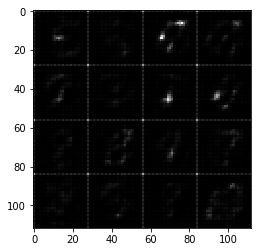

Epoch 1/2... Discriminator Loss: 1.3499 ... Generator Loss: 0.6933
Epoch 1/2... Discriminator Loss: 1.1490 ... Generator Loss: 1.1688
Epoch 1/2... Discriminator Loss: 1.3531 ... Generator Loss: 0.7461
Epoch 1/2... Discriminator Loss: 1.3227 ... Generator Loss: 0.6208
Epoch 1/2... Discriminator Loss: 1.1879 ... Generator Loss: 1.2700
Epoch 1/2... Discriminator Loss: 1.2403 ... Generator Loss: 0.7086
Epoch 1/2... Discriminator Loss: 2.0685 ... Generator Loss: 0.2291
Epoch 1/2... Discriminator Loss: 1.2668 ... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.1000 ... Generator Loss: 0.9622
Epoch 1/2... Discriminator Loss: 1.4960 ... Generator Loss: 0.4545


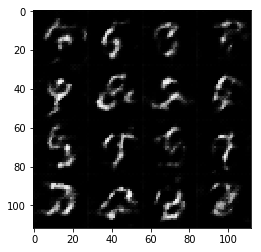

Epoch 1/2... Discriminator Loss: 1.6523 ... Generator Loss: 0.3856
Epoch 1/2... Discriminator Loss: 1.1443 ... Generator Loss: 0.8537
Epoch 1/2... Discriminator Loss: 1.2048 ... Generator Loss: 0.9197
Epoch 1/2... Discriminator Loss: 1.3565 ... Generator Loss: 0.6268
Epoch 1/2... Discriminator Loss: 1.6794 ... Generator Loss: 0.3631
Epoch 1/2... Discriminator Loss: 1.5581 ... Generator Loss: 0.4218
Epoch 1/2... Discriminator Loss: 1.3022 ... Generator Loss: 0.8245
Epoch 1/2... Discriminator Loss: 1.4110 ... Generator Loss: 0.5431
Epoch 1/2... Discriminator Loss: 1.5368 ... Generator Loss: 0.4484
Epoch 1/2... Discriminator Loss: 1.5479 ... Generator Loss: 0.4627


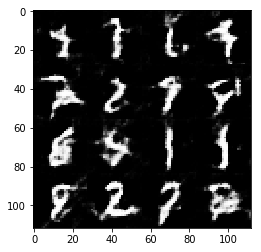

Epoch 1/2... Discriminator Loss: 1.4732 ... Generator Loss: 0.4630
Epoch 1/2... Discriminator Loss: 1.1887 ... Generator Loss: 1.2677
Epoch 1/2... Discriminator Loss: 1.4320 ... Generator Loss: 0.6544
Epoch 1/2... Discriminator Loss: 1.2962 ... Generator Loss: 0.7600
Epoch 1/2... Discriminator Loss: 1.3987 ... Generator Loss: 0.6254
Epoch 1/2... Discriminator Loss: 1.4550 ... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.5295 ... Generator Loss: 0.5155
Epoch 1/2... Discriminator Loss: 1.4188 ... Generator Loss: 0.6015
Epoch 1/2... Discriminator Loss: 1.2156 ... Generator Loss: 0.6637
Epoch 1/2... Discriminator Loss: 1.4404 ... Generator Loss: 0.5302


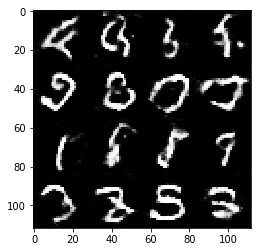

Epoch 1/2... Discriminator Loss: 1.4119 ... Generator Loss: 0.5832
Epoch 1/2... Discriminator Loss: 1.3218 ... Generator Loss: 0.7060
Epoch 1/2... Discriminator Loss: 1.2264 ... Generator Loss: 0.9296
Epoch 1/2... Discriminator Loss: 1.6037 ... Generator Loss: 1.2475
Epoch 1/2... Discriminator Loss: 1.1771 ... Generator Loss: 1.2595
Epoch 1/2... Discriminator Loss: 1.2612 ... Generator Loss: 0.6821
Epoch 1/2... Discriminator Loss: 1.0995 ... Generator Loss: 1.0630
Epoch 1/2... Discriminator Loss: 1.5181 ... Generator Loss: 1.9616
Epoch 1/2... Discriminator Loss: 1.6413 ... Generator Loss: 0.3797
Epoch 1/2... Discriminator Loss: 1.3905 ... Generator Loss: 0.5868


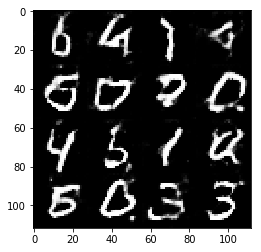

Epoch 1/2... Discriminator Loss: 1.2278 ... Generator Loss: 0.8345
Epoch 1/2... Discriminator Loss: 1.3241 ... Generator Loss: 0.5760
Epoch 1/2... Discriminator Loss: 1.1510 ... Generator Loss: 0.8229
Epoch 1/2... Discriminator Loss: 1.2149 ... Generator Loss: 1.1099
Epoch 1/2... Discriminator Loss: 1.1410 ... Generator Loss: 0.8148
Epoch 1/2... Discriminator Loss: 1.4790 ... Generator Loss: 1.7455
Epoch 1/2... Discriminator Loss: 1.1616 ... Generator Loss: 1.0927
Epoch 1/2... Discriminator Loss: 1.2286 ... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.7708 ... Generator Loss: 0.3526
Epoch 1/2... Discriminator Loss: 1.2653 ... Generator Loss: 0.7018


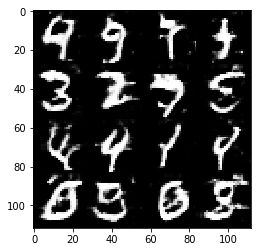

Epoch 1/2... Discriminator Loss: 1.2251 ... Generator Loss: 0.8767
Epoch 1/2... Discriminator Loss: 1.1143 ... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.9270 ... Generator Loss: 0.2590
Epoch 1/2... Discriminator Loss: 1.2953 ... Generator Loss: 0.8836
Epoch 1/2... Discriminator Loss: 1.1551 ... Generator Loss: 0.7310
Epoch 1/2... Discriminator Loss: 1.1279 ... Generator Loss: 1.7015
Epoch 1/2... Discriminator Loss: 1.2273 ... Generator Loss: 1.3202
Epoch 1/2... Discriminator Loss: 1.3386 ... Generator Loss: 0.5373
Epoch 1/2... Discriminator Loss: 1.2217 ... Generator Loss: 0.6412
Epoch 1/2... Discriminator Loss: 1.1875 ... Generator Loss: 0.6719


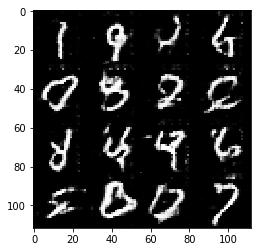

Epoch 1/2... Discriminator Loss: 1.4454 ... Generator Loss: 0.5353
Epoch 1/2... Discriminator Loss: 1.0610 ... Generator Loss: 0.9746
Epoch 1/2... Discriminator Loss: 1.3045 ... Generator Loss: 0.5900
Epoch 1/2... Discriminator Loss: 1.1850 ... Generator Loss: 0.9630
Epoch 1/2... Discriminator Loss: 1.2370 ... Generator Loss: 0.6282
Epoch 1/2... Discriminator Loss: 0.9367 ... Generator Loss: 1.2624
Epoch 1/2... Discriminator Loss: 1.1855 ... Generator Loss: 0.9197
Epoch 1/2... Discriminator Loss: 1.0982 ... Generator Loss: 0.8941
Epoch 1/2... Discriminator Loss: 1.1323 ... Generator Loss: 0.8393
Epoch 1/2... Discriminator Loss: 2.0183 ... Generator Loss: 0.2354


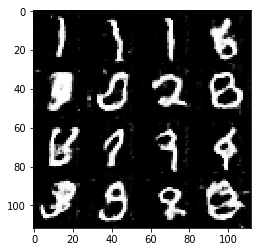

Epoch 1/2... Discriminator Loss: 1.0987 ... Generator Loss: 1.6272
Epoch 1/2... Discriminator Loss: 1.0743 ... Generator Loss: 0.8391
Epoch 1/2... Discriminator Loss: 1.1566 ... Generator Loss: 0.7713
Epoch 1/2... Discriminator Loss: 1.1440 ... Generator Loss: 1.0765
Epoch 1/2... Discriminator Loss: 1.3983 ... Generator Loss: 0.5168
Epoch 1/2... Discriminator Loss: 1.4009 ... Generator Loss: 0.5765
Epoch 1/2... Discriminator Loss: 1.1682 ... Generator Loss: 0.7093
Epoch 1/2... Discriminator Loss: 1.4691 ... Generator Loss: 0.5135
Epoch 1/2... Discriminator Loss: 1.0749 ... Generator Loss: 1.3821
Epoch 1/2... Discriminator Loss: 0.8900 ... Generator Loss: 1.1028


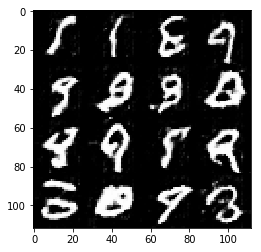

Epoch 1/2... Discriminator Loss: 1.0765 ... Generator Loss: 1.8426
Epoch 1/2... Discriminator Loss: 0.8499 ... Generator Loss: 1.4743
Epoch 1/2... Discriminator Loss: 1.1023 ... Generator Loss: 0.8215
Epoch 1/2... Discriminator Loss: 1.4773 ... Generator Loss: 0.5090
Epoch 1/2... Discriminator Loss: 1.1240 ... Generator Loss: 1.0495
Epoch 1/2... Discriminator Loss: 1.0506 ... Generator Loss: 1.0722
Epoch 1/2... Discriminator Loss: 1.1349 ... Generator Loss: 0.8581
Epoch 1/2... Discriminator Loss: 1.4702 ... Generator Loss: 0.4607
Epoch 1/2... Discriminator Loss: 1.3216 ... Generator Loss: 0.5359
Epoch 1/2... Discriminator Loss: 1.3172 ... Generator Loss: 0.6331


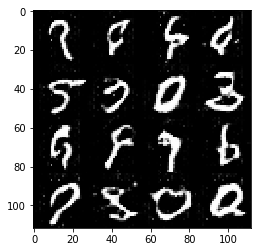

Epoch 1/2... Discriminator Loss: 1.3015 ... Generator Loss: 0.7609
Epoch 1/2... Discriminator Loss: 1.1290 ... Generator Loss: 1.1764
Epoch 1/2... Discriminator Loss: 1.1383 ... Generator Loss: 0.7253
Epoch 1/2... Discriminator Loss: 1.0866 ... Generator Loss: 0.9657
Epoch 1/2... Discriminator Loss: 1.0278 ... Generator Loss: 0.9586
Epoch 1/2... Discriminator Loss: 1.1367 ... Generator Loss: 1.4578
Epoch 1/2... Discriminator Loss: 1.1381 ... Generator Loss: 0.6853
Epoch 1/2... Discriminator Loss: 0.9733 ... Generator Loss: 1.1791
Epoch 1/2... Discriminator Loss: 0.8496 ... Generator Loss: 1.0769
Epoch 1/2... Discriminator Loss: 1.6667 ... Generator Loss: 0.3671


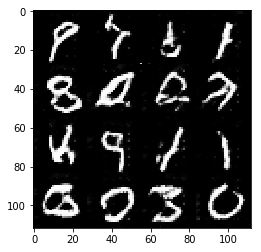

Epoch 1/2... Discriminator Loss: 1.2339 ... Generator Loss: 0.6967
Epoch 1/2... Discriminator Loss: 1.1267 ... Generator Loss: 1.0964
Epoch 1/2... Discriminator Loss: 1.2725 ... Generator Loss: 0.6594
Epoch 1/2... Discriminator Loss: 1.6433 ... Generator Loss: 0.3936
Epoch 1/2... Discriminator Loss: 1.0924 ... Generator Loss: 1.2259
Epoch 1/2... Discriminator Loss: 1.0382 ... Generator Loss: 1.0658
Epoch 1/2... Discriminator Loss: 1.0746 ... Generator Loss: 0.8117
Epoch 1/2... Discriminator Loss: 0.9235 ... Generator Loss: 0.9808
Epoch 1/2... Discriminator Loss: 1.0472 ... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 0.9705 ... Generator Loss: 1.1868


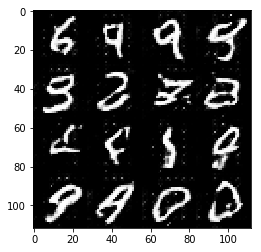

Epoch 1/2... Discriminator Loss: 1.1514 ... Generator Loss: 0.7980
Epoch 1/2... Discriminator Loss: 0.9860 ... Generator Loss: 1.4295
Epoch 1/2... Discriminator Loss: 1.3471 ... Generator Loss: 0.6093
Epoch 1/2... Discriminator Loss: 1.1144 ... Generator Loss: 0.8151
Epoch 1/2... Discriminator Loss: 1.5233 ... Generator Loss: 0.4961
Epoch 1/2... Discriminator Loss: 1.3977 ... Generator Loss: 1.6944
Epoch 1/2... Discriminator Loss: 1.3349 ... Generator Loss: 0.5838
Epoch 1/2... Discriminator Loss: 1.0268 ... Generator Loss: 0.9531
Epoch 1/2... Discriminator Loss: 1.3754 ... Generator Loss: 0.5313
Epoch 1/2... Discriminator Loss: 1.1576 ... Generator Loss: 1.0745


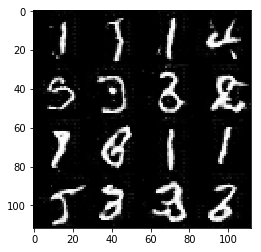

Epoch 1/2... Discriminator Loss: 0.9600 ... Generator Loss: 1.5493
Epoch 1/2... Discriminator Loss: 1.2028 ... Generator Loss: 0.6668
Epoch 1/2... Discriminator Loss: 1.2521 ... Generator Loss: 0.7195
Epoch 1/2... Discriminator Loss: 1.0248 ... Generator Loss: 1.4164
Epoch 1/2... Discriminator Loss: 1.3703 ... Generator Loss: 0.5602
Epoch 1/2... Discriminator Loss: 1.3807 ... Generator Loss: 0.5970
Epoch 1/2... Discriminator Loss: 1.5109 ... Generator Loss: 0.4315
Epoch 1/2... Discriminator Loss: 1.1244 ... Generator Loss: 1.6408
Epoch 1/2... Discriminator Loss: 0.8674 ... Generator Loss: 1.1207
Epoch 1/2... Discriminator Loss: 1.2651 ... Generator Loss: 0.7192


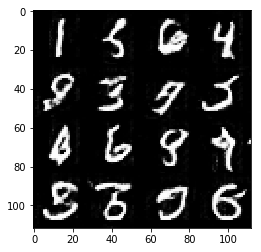

Epoch 1/2... Discriminator Loss: 0.8917 ... Generator Loss: 1.1076
Epoch 1/2... Discriminator Loss: 0.9100 ... Generator Loss: 1.1163
Epoch 1/2... Discriminator Loss: 1.1893 ... Generator Loss: 0.7266
Epoch 1/2... Discriminator Loss: 1.2868 ... Generator Loss: 0.6725
Epoch 1/2... Discriminator Loss: 1.0585 ... Generator Loss: 0.8121
Epoch 1/2... Discriminator Loss: 0.9379 ... Generator Loss: 1.7547
Epoch 1/2... Discriminator Loss: 1.2861 ... Generator Loss: 0.5677
Epoch 1/2... Discriminator Loss: 0.9428 ... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.4081 ... Generator Loss: 2.2452
Epoch 1/2... Discriminator Loss: 1.2750 ... Generator Loss: 0.6094


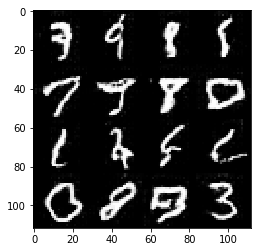

Epoch 1/2... Discriminator Loss: 1.1962 ... Generator Loss: 0.7700
Epoch 1/2... Discriminator Loss: 0.9173 ... Generator Loss: 1.0567
Epoch 1/2... Discriminator Loss: 1.2412 ... Generator Loss: 0.6329
Epoch 1/2... Discriminator Loss: 0.7799 ... Generator Loss: 1.6273
Epoch 1/2... Discriminator Loss: 1.2321 ... Generator Loss: 0.6063
Epoch 1/2... Discriminator Loss: 1.0303 ... Generator Loss: 1.2198
Epoch 1/2... Discriminator Loss: 0.8245 ... Generator Loss: 1.4727
Epoch 1/2... Discriminator Loss: 0.9838 ... Generator Loss: 1.0162
Epoch 1/2... Discriminator Loss: 1.4419 ... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 1.0595 ... Generator Loss: 0.8951


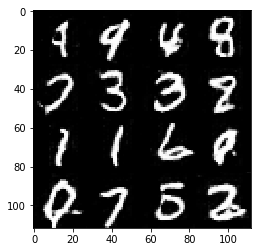

Epoch 1/2... Discriminator Loss: 1.0903 ... Generator Loss: 1.0395
Epoch 1/2... Discriminator Loss: 1.2646 ... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 0.9667 ... Generator Loss: 1.5177
Epoch 1/2... Discriminator Loss: 0.9213 ... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 0.7685 ... Generator Loss: 1.5907
Epoch 1/2... Discriminator Loss: 1.1976 ... Generator Loss: 1.3578
Epoch 1/2... Discriminator Loss: 1.1951 ... Generator Loss: 0.8411
Epoch 1/2... Discriminator Loss: 0.7256 ... Generator Loss: 1.6131
Epoch 1/2... Discriminator Loss: 1.1804 ... Generator Loss: 0.8047
Epoch 1/2... Discriminator Loss: 1.1457 ... Generator Loss: 0.8141


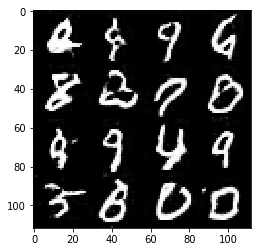

Epoch 1/2... Discriminator Loss: 0.8058 ... Generator Loss: 1.3035
Epoch 1/2... Discriminator Loss: 0.9190 ... Generator Loss: 1.5975
Epoch 1/2... Discriminator Loss: 1.1259 ... Generator Loss: 1.1861
Epoch 1/2... Discriminator Loss: 1.0698 ... Generator Loss: 1.1298
Epoch 1/2... Discriminator Loss: 1.1991 ... Generator Loss: 0.6982
Epoch 1/2... Discriminator Loss: 0.9787 ... Generator Loss: 1.0010
Epoch 1/2... Discriminator Loss: 1.3355 ... Generator Loss: 0.5834
Epoch 1/2... Discriminator Loss: 0.9929 ... Generator Loss: 1.8843
Epoch 1/2... Discriminator Loss: 0.8845 ... Generator Loss: 1.4224
Epoch 1/2... Discriminator Loss: 0.9374 ... Generator Loss: 1.3068


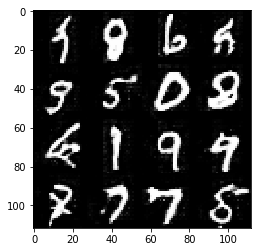

Epoch 1/2... Discriminator Loss: 1.2562 ... Generator Loss: 0.6485
Epoch 1/2... Discriminator Loss: 1.0210 ... Generator Loss: 0.8532
Epoch 1/2... Discriminator Loss: 1.0026 ... Generator Loss: 1.1745
Epoch 1/2... Discriminator Loss: 1.1668 ... Generator Loss: 0.7542
Epoch 1/2... Discriminator Loss: 0.9714 ... Generator Loss: 1.1898
Epoch 1/2... Discriminator Loss: 2.0134 ... Generator Loss: 0.2730
Epoch 1/2... Discriminator Loss: 0.9598 ... Generator Loss: 1.0926
Epoch 2/2... Discriminator Loss: 1.0135 ... Generator Loss: 0.9169
Epoch 2/2... Discriminator Loss: 0.9385 ... Generator Loss: 0.9825
Epoch 2/2... Discriminator Loss: 0.9880 ... Generator Loss: 1.1998


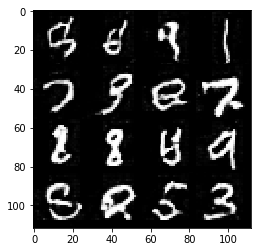

Epoch 2/2... Discriminator Loss: 1.0764 ... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 1.1197 ... Generator Loss: 0.7744
Epoch 2/2... Discriminator Loss: 1.7191 ... Generator Loss: 2.0050
Epoch 2/2... Discriminator Loss: 1.1246 ... Generator Loss: 0.9842
Epoch 2/2... Discriminator Loss: 0.8750 ... Generator Loss: 1.1910
Epoch 2/2... Discriminator Loss: 1.0666 ... Generator Loss: 0.9436
Epoch 2/2... Discriminator Loss: 1.4384 ... Generator Loss: 0.6644
Epoch 2/2... Discriminator Loss: 1.2184 ... Generator Loss: 0.8321
Epoch 2/2... Discriminator Loss: 0.9664 ... Generator Loss: 1.0265
Epoch 2/2... Discriminator Loss: 0.9422 ... Generator Loss: 1.1787


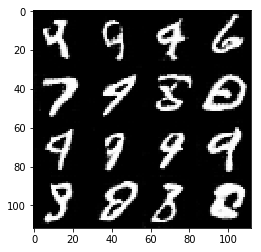

Epoch 2/2... Discriminator Loss: 0.9206 ... Generator Loss: 1.0561
Epoch 2/2... Discriminator Loss: 0.9791 ... Generator Loss: 1.0114
Epoch 2/2... Discriminator Loss: 1.1770 ... Generator Loss: 0.7065
Epoch 2/2... Discriminator Loss: 0.7432 ... Generator Loss: 1.6689
Epoch 2/2... Discriminator Loss: 1.0140 ... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 1.0053 ... Generator Loss: 0.9540
Epoch 2/2... Discriminator Loss: 0.9733 ... Generator Loss: 1.0946
Epoch 2/2... Discriminator Loss: 1.2011 ... Generator Loss: 0.8547
Epoch 2/2... Discriminator Loss: 0.7930 ... Generator Loss: 1.4449
Epoch 2/2... Discriminator Loss: 1.0480 ... Generator Loss: 1.8262


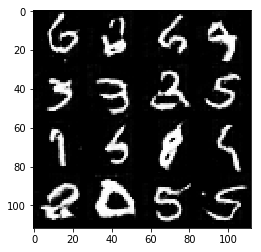

Epoch 2/2... Discriminator Loss: 1.0031 ... Generator Loss: 0.9886
Epoch 2/2... Discriminator Loss: 1.0039 ... Generator Loss: 1.4367
Epoch 2/2... Discriminator Loss: 0.8990 ... Generator Loss: 1.0822
Epoch 2/2... Discriminator Loss: 1.0187 ... Generator Loss: 0.9295
Epoch 2/2... Discriminator Loss: 1.6813 ... Generator Loss: 0.3938
Epoch 2/2... Discriminator Loss: 1.4762 ... Generator Loss: 0.4748
Epoch 2/2... Discriminator Loss: 0.8575 ... Generator Loss: 1.3272
Epoch 2/2... Discriminator Loss: 1.0393 ... Generator Loss: 1.3608
Epoch 2/2... Discriminator Loss: 0.8209 ... Generator Loss: 1.1690
Epoch 2/2... Discriminator Loss: 1.0727 ... Generator Loss: 0.8228


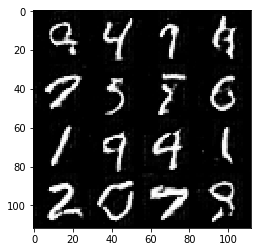

Epoch 2/2... Discriminator Loss: 0.8327 ... Generator Loss: 1.4139
Epoch 2/2... Discriminator Loss: 0.7174 ... Generator Loss: 1.3666
Epoch 2/2... Discriminator Loss: 2.5924 ... Generator Loss: 0.1749
Epoch 2/2... Discriminator Loss: 0.7772 ... Generator Loss: 1.6167
Epoch 2/2... Discriminator Loss: 0.9553 ... Generator Loss: 1.1686
Epoch 2/2... Discriminator Loss: 1.1105 ... Generator Loss: 0.8443
Epoch 2/2... Discriminator Loss: 0.9853 ... Generator Loss: 1.1188
Epoch 2/2... Discriminator Loss: 1.0024 ... Generator Loss: 0.9614
Epoch 2/2... Discriminator Loss: 1.5038 ... Generator Loss: 0.5600
Epoch 2/2... Discriminator Loss: 0.8178 ... Generator Loss: 1.4812


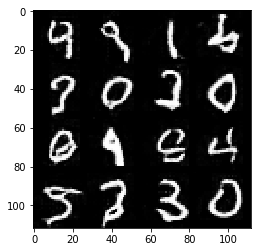

Epoch 2/2... Discriminator Loss: 0.8379 ... Generator Loss: 1.3397
Epoch 2/2... Discriminator Loss: 0.8987 ... Generator Loss: 1.1007
Epoch 2/2... Discriminator Loss: 1.0299 ... Generator Loss: 1.0519
Epoch 2/2... Discriminator Loss: 1.1005 ... Generator Loss: 2.3643
Epoch 2/2... Discriminator Loss: 0.7752 ... Generator Loss: 1.5369
Epoch 2/2... Discriminator Loss: 1.3389 ... Generator Loss: 0.5581
Epoch 2/2... Discriminator Loss: 0.8459 ... Generator Loss: 1.2568
Epoch 2/2... Discriminator Loss: 1.0132 ... Generator Loss: 0.9726
Epoch 2/2... Discriminator Loss: 0.8761 ... Generator Loss: 1.0621
Epoch 2/2... Discriminator Loss: 1.2750 ... Generator Loss: 0.6123


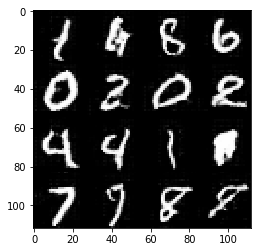

Epoch 2/2... Discriminator Loss: 0.9936 ... Generator Loss: 0.9270
Epoch 2/2... Discriminator Loss: 1.0870 ... Generator Loss: 0.8557
Epoch 2/2... Discriminator Loss: 0.9012 ... Generator Loss: 1.0999
Epoch 2/2... Discriminator Loss: 1.0190 ... Generator Loss: 1.0058
Epoch 2/2... Discriminator Loss: 0.9093 ... Generator Loss: 1.2982
Epoch 2/2... Discriminator Loss: 0.8064 ... Generator Loss: 1.1917
Epoch 2/2... Discriminator Loss: 0.9688 ... Generator Loss: 1.2394
Epoch 2/2... Discriminator Loss: 0.8038 ... Generator Loss: 1.2070
Epoch 2/2... Discriminator Loss: 0.9240 ... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 1.0316 ... Generator Loss: 2.0343


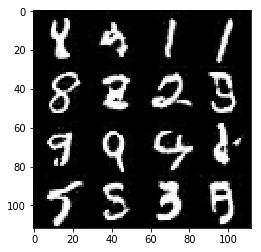

Epoch 2/2... Discriminator Loss: 1.0081 ... Generator Loss: 1.6305
Epoch 2/2... Discriminator Loss: 0.8608 ... Generator Loss: 1.2055
Epoch 2/2... Discriminator Loss: 0.8724 ... Generator Loss: 1.2101
Epoch 2/2... Discriminator Loss: 1.0317 ... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 1.3106 ... Generator Loss: 0.5651
Epoch 2/2... Discriminator Loss: 1.0957 ... Generator Loss: 0.7641
Epoch 2/2... Discriminator Loss: 1.0166 ... Generator Loss: 0.8832
Epoch 2/2... Discriminator Loss: 0.7862 ... Generator Loss: 1.4068
Epoch 2/2... Discriminator Loss: 1.6676 ... Generator Loss: 0.4218
Epoch 2/2... Discriminator Loss: 1.0649 ... Generator Loss: 0.9828


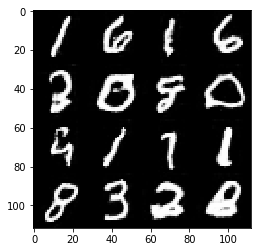

Epoch 2/2... Discriminator Loss: 0.9526 ... Generator Loss: 0.9419
Epoch 2/2... Discriminator Loss: 1.4700 ... Generator Loss: 0.5320
Epoch 2/2... Discriminator Loss: 0.9006 ... Generator Loss: 1.0907
Epoch 2/2... Discriminator Loss: 1.2712 ... Generator Loss: 0.7239
Epoch 2/2... Discriminator Loss: 1.1437 ... Generator Loss: 0.9220
Epoch 2/2... Discriminator Loss: 0.9931 ... Generator Loss: 1.5462
Epoch 2/2... Discriminator Loss: 0.8100 ... Generator Loss: 1.4398
Epoch 2/2... Discriminator Loss: 1.0416 ... Generator Loss: 2.1909
Epoch 2/2... Discriminator Loss: 0.8490 ... Generator Loss: 1.1128
Epoch 2/2... Discriminator Loss: 1.2786 ... Generator Loss: 0.6506


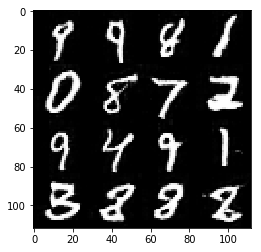

Epoch 2/2... Discriminator Loss: 0.9748 ... Generator Loss: 1.0203
Epoch 2/2... Discriminator Loss: 0.6923 ... Generator Loss: 1.4934
Epoch 2/2... Discriminator Loss: 1.1252 ... Generator Loss: 0.8219
Epoch 2/2... Discriminator Loss: 0.8044 ... Generator Loss: 1.6673
Epoch 2/2... Discriminator Loss: 0.8041 ... Generator Loss: 1.2736
Epoch 2/2... Discriminator Loss: 1.1198 ... Generator Loss: 0.7902
Epoch 2/2... Discriminator Loss: 0.8532 ... Generator Loss: 1.7249
Epoch 2/2... Discriminator Loss: 0.9172 ... Generator Loss: 1.8460
Epoch 2/2... Discriminator Loss: 1.0448 ... Generator Loss: 1.0774
Epoch 2/2... Discriminator Loss: 0.9465 ... Generator Loss: 1.1832


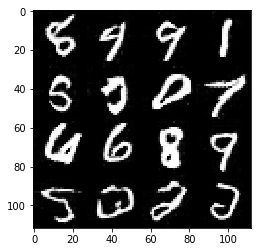

Epoch 2/2... Discriminator Loss: 0.9506 ... Generator Loss: 1.1771
Epoch 2/2... Discriminator Loss: 1.0802 ... Generator Loss: 0.7900
Epoch 2/2... Discriminator Loss: 0.8386 ... Generator Loss: 1.2228
Epoch 2/2... Discriminator Loss: 0.9477 ... Generator Loss: 1.0780
Epoch 2/2... Discriminator Loss: 1.2735 ... Generator Loss: 0.6140
Epoch 2/2... Discriminator Loss: 1.3847 ... Generator Loss: 0.5377
Epoch 2/2... Discriminator Loss: 1.0031 ... Generator Loss: 0.9546
Epoch 2/2... Discriminator Loss: 0.6949 ... Generator Loss: 1.6431
Epoch 2/2... Discriminator Loss: 0.8456 ... Generator Loss: 1.3210
Epoch 2/2... Discriminator Loss: 1.0701 ... Generator Loss: 1.0191


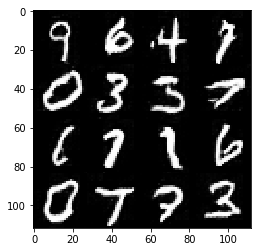

Epoch 2/2... Discriminator Loss: 0.8308 ... Generator Loss: 1.7602
Epoch 2/2... Discriminator Loss: 0.9669 ... Generator Loss: 1.0462
Epoch 2/2... Discriminator Loss: 0.7518 ... Generator Loss: 1.3172
Epoch 2/2... Discriminator Loss: 1.1965 ... Generator Loss: 0.6747
Epoch 2/2... Discriminator Loss: 0.7273 ... Generator Loss: 1.6093
Epoch 2/2... Discriminator Loss: 0.7070 ... Generator Loss: 1.7777
Epoch 2/2... Discriminator Loss: 0.8205 ... Generator Loss: 1.3396
Epoch 2/2... Discriminator Loss: 0.8172 ... Generator Loss: 1.4577
Epoch 2/2... Discriminator Loss: 1.0152 ... Generator Loss: 1.1196
Epoch 2/2... Discriminator Loss: 1.1538 ... Generator Loss: 0.7756


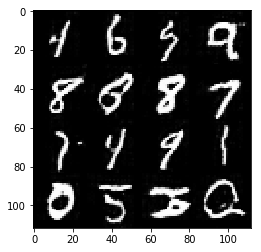

Epoch 2/2... Discriminator Loss: 1.0514 ... Generator Loss: 1.0221
Epoch 2/2... Discriminator Loss: 1.0090 ... Generator Loss: 2.0853
Epoch 2/2... Discriminator Loss: 0.9920 ... Generator Loss: 1.3480
Epoch 2/2... Discriminator Loss: 0.8560 ... Generator Loss: 1.1820
Epoch 2/2... Discriminator Loss: 0.8110 ... Generator Loss: 1.2608
Epoch 2/2... Discriminator Loss: 0.7882 ... Generator Loss: 1.3820
Epoch 2/2... Discriminator Loss: 0.8207 ... Generator Loss: 1.3107
Epoch 2/2... Discriminator Loss: 0.9385 ... Generator Loss: 1.0405
Epoch 2/2... Discriminator Loss: 1.1894 ... Generator Loss: 0.7570
Epoch 2/2... Discriminator Loss: 0.8520 ... Generator Loss: 1.1591


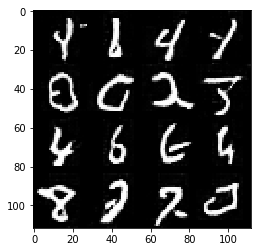

Epoch 2/2... Discriminator Loss: 0.7694 ... Generator Loss: 1.3510
Epoch 2/2... Discriminator Loss: 0.7754 ... Generator Loss: 1.7735
Epoch 2/2... Discriminator Loss: 1.0548 ... Generator Loss: 0.9998
Epoch 2/2... Discriminator Loss: 1.0747 ... Generator Loss: 0.8240
Epoch 2/2... Discriminator Loss: 0.7452 ... Generator Loss: 1.7601
Epoch 2/2... Discriminator Loss: 1.1557 ... Generator Loss: 0.7296
Epoch 2/2... Discriminator Loss: 0.8921 ... Generator Loss: 1.3677
Epoch 2/2... Discriminator Loss: 0.9902 ... Generator Loss: 1.2423
Epoch 2/2... Discriminator Loss: 0.9070 ... Generator Loss: 1.0809
Epoch 2/2... Discriminator Loss: 0.9078 ... Generator Loss: 1.5373


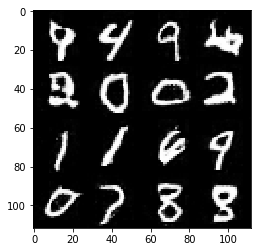

Epoch 2/2... Discriminator Loss: 0.9821 ... Generator Loss: 1.1044
Epoch 2/2... Discriminator Loss: 1.0992 ... Generator Loss: 1.1260
Epoch 2/2... Discriminator Loss: 1.6160 ... Generator Loss: 0.4864
Epoch 2/2... Discriminator Loss: 1.1178 ... Generator Loss: 1.9432
Epoch 2/2... Discriminator Loss: 0.8779 ... Generator Loss: 1.9163
Epoch 2/2... Discriminator Loss: 0.7890 ... Generator Loss: 1.5795
Epoch 2/2... Discriminator Loss: 1.5512 ... Generator Loss: 0.4699
Epoch 2/2... Discriminator Loss: 1.0607 ... Generator Loss: 0.9355
Epoch 2/2... Discriminator Loss: 1.0254 ... Generator Loss: 0.8670
Epoch 2/2... Discriminator Loss: 1.0107 ... Generator Loss: 0.9117


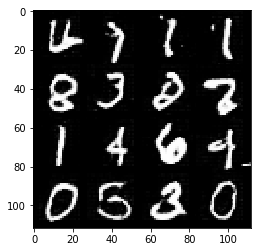

Epoch 2/2... Discriminator Loss: 0.7594 ... Generator Loss: 1.3226
Epoch 2/2... Discriminator Loss: 0.6752 ... Generator Loss: 1.6807
Epoch 2/2... Discriminator Loss: 0.8950 ... Generator Loss: 1.6782
Epoch 2/2... Discriminator Loss: 0.8265 ... Generator Loss: 1.3240
Epoch 2/2... Discriminator Loss: 1.1411 ... Generator Loss: 1.7103
Epoch 2/2... Discriminator Loss: 0.6749 ... Generator Loss: 1.6265
Epoch 2/2... Discriminator Loss: 1.7610 ... Generator Loss: 0.3941
Epoch 2/2... Discriminator Loss: 1.1928 ... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 1.2312 ... Generator Loss: 0.7957
Epoch 2/2... Discriminator Loss: 1.3752 ... Generator Loss: 0.5498


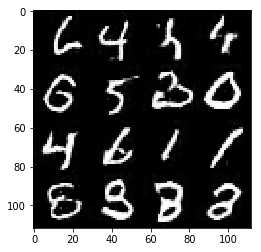

Epoch 2/2... Discriminator Loss: 1.3306 ... Generator Loss: 0.5865
Epoch 2/2... Discriminator Loss: 0.6735 ... Generator Loss: 1.8671
Epoch 2/2... Discriminator Loss: 1.1873 ... Generator Loss: 0.6953
Epoch 2/2... Discriminator Loss: 1.0265 ... Generator Loss: 0.8882
Epoch 2/2... Discriminator Loss: 1.0730 ... Generator Loss: 1.1027
Epoch 2/2... Discriminator Loss: 1.0389 ... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 0.8591 ... Generator Loss: 1.1828
Epoch 2/2... Discriminator Loss: 0.8034 ... Generator Loss: 1.7735
Epoch 2/2... Discriminator Loss: 0.9064 ... Generator Loss: 1.2773
Epoch 2/2... Discriminator Loss: 0.9893 ... Generator Loss: 0.9940


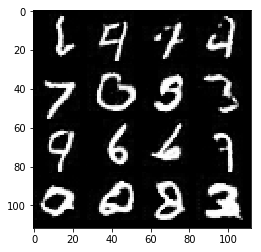

Epoch 2/2... Discriminator Loss: 0.9420 ... Generator Loss: 1.0700
Epoch 2/2... Discriminator Loss: 0.7694 ... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.9358 ... Generator Loss: 0.9959
Epoch 2/2... Discriminator Loss: 0.8029 ... Generator Loss: 1.3034
Epoch 2/2... Discriminator Loss: 0.7826 ... Generator Loss: 1.2379
Epoch 2/2... Discriminator Loss: 0.8479 ... Generator Loss: 1.1790
Epoch 2/2... Discriminator Loss: 1.1063 ... Generator Loss: 0.8432
Epoch 2/2... Discriminator Loss: 1.0944 ... Generator Loss: 0.8712
Epoch 2/2... Discriminator Loss: 2.4662 ... Generator Loss: 0.2916
Epoch 2/2... Discriminator Loss: 1.4707 ... Generator Loss: 0.5194


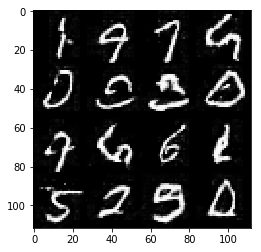

Epoch 2/2... Discriminator Loss: 0.6548 ... Generator Loss: 2.6812
Epoch 2/2... Discriminator Loss: 1.1544 ... Generator Loss: 0.7450
Epoch 2/2... Discriminator Loss: 0.9139 ... Generator Loss: 1.0088
Epoch 2/2... Discriminator Loss: 0.8945 ... Generator Loss: 1.2706
Epoch 2/2... Discriminator Loss: 0.7132 ... Generator Loss: 1.4556
Epoch 2/2... Discriminator Loss: 1.2729 ... Generator Loss: 0.6401
Epoch 2/2... Discriminator Loss: 0.9730 ... Generator Loss: 1.5804
Epoch 2/2... Discriminator Loss: 1.0802 ... Generator Loss: 0.8635
Epoch 2/2... Discriminator Loss: 0.9729 ... Generator Loss: 1.0283
Epoch 2/2... Discriminator Loss: 0.8748 ... Generator Loss: 1.2030


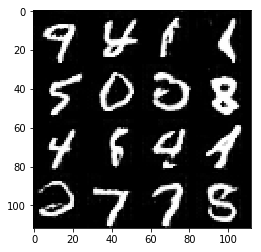

Epoch 2/2... Discriminator Loss: 1.1109 ... Generator Loss: 1.7259
Epoch 2/2... Discriminator Loss: 1.3496 ... Generator Loss: 0.5638
Epoch 2/2... Discriminator Loss: 1.2718 ... Generator Loss: 0.5906
Epoch 2/2... Discriminator Loss: 0.9188 ... Generator Loss: 1.0298
Epoch 2/2... Discriminator Loss: 0.7745 ... Generator Loss: 1.6114
Finished


In [11]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5
tf.reset_default_graph() # saw on slack

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.6309 ... Generator Loss: 0.4714
Epoch 1/1... Discriminator Loss: 1.3244 ... Generator Loss: 2.0593
Epoch 1/1... Discriminator Loss: 2.7056 ... Generator Loss: 0.1309
Epoch 1/1... Discriminator Loss: 1.4051 ... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.1906 ... Generator Loss: 2.4203
Epoch 1/1... Discriminator Loss: 1.4110 ... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.0602 ... Generator Loss: 0.8199
Epoch 1/1... Discriminator Loss: 1.0785 ... Generator Loss: 0.8632
Epoch 1/1... Discriminator Loss: 0.7079 ... Generator Loss: 1.5630
Epoch 1/1... Discriminator Loss: 2.1397 ... Generator Loss: 0.2497


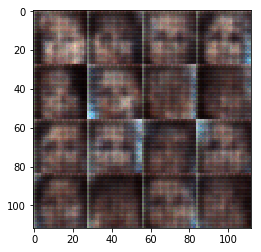

Epoch 1/1... Discriminator Loss: 0.9376 ... Generator Loss: 1.0940
Epoch 1/1... Discriminator Loss: 1.5595 ... Generator Loss: 0.9065
Epoch 1/1... Discriminator Loss: 2.2250 ... Generator Loss: 0.2480
Epoch 1/1... Discriminator Loss: 1.1865 ... Generator Loss: 0.9885
Epoch 1/1... Discriminator Loss: 1.2314 ... Generator Loss: 0.9937
Epoch 1/1... Discriminator Loss: 1.5131 ... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.6977 ... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.5148 ... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.6800 ... Generator Loss: 0.4324
Epoch 1/1... Discriminator Loss: 1.6571 ... Generator Loss: 0.4525


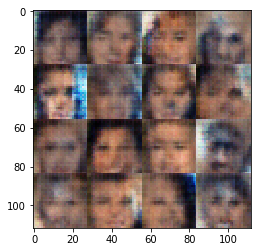

Epoch 1/1... Discriminator Loss: 1.7089 ... Generator Loss: 0.9477
Epoch 1/1... Discriminator Loss: 1.4131 ... Generator Loss: 1.1620
Epoch 1/1... Discriminator Loss: 1.3211 ... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4492 ... Generator Loss: 1.2801
Epoch 1/1... Discriminator Loss: 1.7015 ... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.5355 ... Generator Loss: 0.4929
Epoch 1/1... Discriminator Loss: 1.1227 ... Generator Loss: 1.2460
Epoch 1/1... Discriminator Loss: 1.6665 ... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.6909 ... Generator Loss: 1.2268
Epoch 1/1... Discriminator Loss: 1.5896 ... Generator Loss: 0.6127


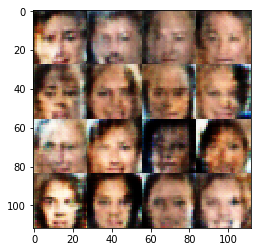

Epoch 1/1... Discriminator Loss: 1.1554 ... Generator Loss: 0.8035
Epoch 1/1... Discriminator Loss: 1.2874 ... Generator Loss: 0.5822
Epoch 1/1... Discriminator Loss: 1.9923 ... Generator Loss: 1.4493
Epoch 1/1... Discriminator Loss: 1.8260 ... Generator Loss: 0.3166
Epoch 1/1... Discriminator Loss: 1.4558 ... Generator Loss: 0.5644
Epoch 1/1... Discriminator Loss: 1.2294 ... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3192 ... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.6159 ... Generator Loss: 0.4359
Epoch 1/1... Discriminator Loss: 1.5349 ... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 1.3132 ... Generator Loss: 0.5734


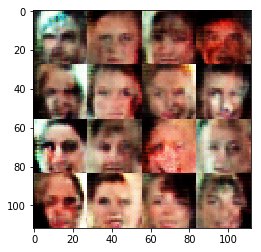

Epoch 1/1... Discriminator Loss: 0.9427 ... Generator Loss: 1.3047
Epoch 1/1... Discriminator Loss: 1.1751 ... Generator Loss: 1.6856
Epoch 1/1... Discriminator Loss: 1.7337 ... Generator Loss: 0.3328
Epoch 1/1... Discriminator Loss: 1.4422 ... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.3916 ... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 0.9135 ... Generator Loss: 1.7505
Epoch 1/1... Discriminator Loss: 1.4633 ... Generator Loss: 0.4944
Epoch 1/1... Discriminator Loss: 1.5370 ... Generator Loss: 0.7904
Epoch 1/1... Discriminator Loss: 1.3575 ... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 1.5271 ... Generator Loss: 1.2951


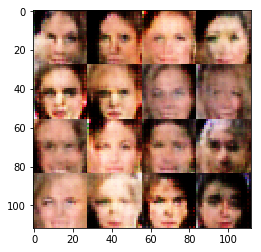

Epoch 1/1... Discriminator Loss: 1.3333 ... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4701 ... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.6242 ... Generator Loss: 0.4090
Epoch 1/1... Discriminator Loss: 1.5042 ... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.3979 ... Generator Loss: 0.6946
Epoch 1/1... Discriminator Loss: 1.5272 ... Generator Loss: 0.4719
Epoch 1/1... Discriminator Loss: 1.2845 ... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.2051 ... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.1494 ... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.5274 ... Generator Loss: 0.5313


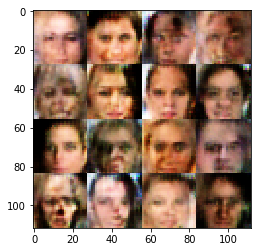

Epoch 1/1... Discriminator Loss: 1.3037 ... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3925 ... Generator Loss: 1.1252
Epoch 1/1... Discriminator Loss: 1.3858 ... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.4158 ... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.2616 ... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.2032 ... Generator Loss: 1.0428
Epoch 1/1... Discriminator Loss: 1.2647 ... Generator Loss: 1.0450
Epoch 1/1... Discriminator Loss: 1.4423 ... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.4316 ... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.3850 ... Generator Loss: 1.0072


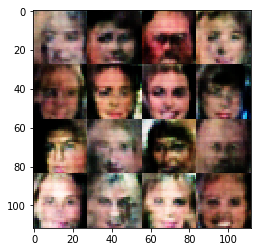

Epoch 1/1... Discriminator Loss: 1.4143 ... Generator Loss: 0.7926
Epoch 1/1... Discriminator Loss: 1.2589 ... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.5392 ... Generator Loss: 1.6514
Epoch 1/1... Discriminator Loss: 1.4368 ... Generator Loss: 0.6623
Epoch 1/1... Discriminator Loss: 1.2542 ... Generator Loss: 1.1000
Epoch 1/1... Discriminator Loss: 1.4808 ... Generator Loss: 0.5586
Epoch 1/1... Discriminator Loss: 1.3858 ... Generator Loss: 0.7053
Epoch 1/1... Discriminator Loss: 1.4016 ... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4797 ... Generator Loss: 0.5161
Epoch 1/1... Discriminator Loss: 1.3650 ... Generator Loss: 0.7480


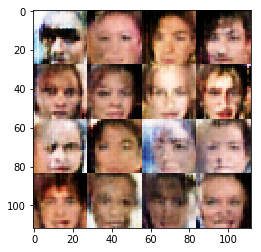

Epoch 1/1... Discriminator Loss: 1.3128 ... Generator Loss: 0.6315
Epoch 1/1... Discriminator Loss: 1.3981 ... Generator Loss: 0.5601
Epoch 1/1... Discriminator Loss: 1.5379 ... Generator Loss: 0.4976
Epoch 1/1... Discriminator Loss: 1.3505 ... Generator Loss: 0.8845
Epoch 1/1... Discriminator Loss: 1.1637 ... Generator Loss: 1.1274
Epoch 1/1... Discriminator Loss: 1.1694 ... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.9853 ... Generator Loss: 0.2490
Epoch 1/1... Discriminator Loss: 1.6733 ... Generator Loss: 0.3979
Epoch 1/1... Discriminator Loss: 1.2762 ... Generator Loss: 0.8928
Epoch 1/1... Discriminator Loss: 1.1655 ... Generator Loss: 1.0684


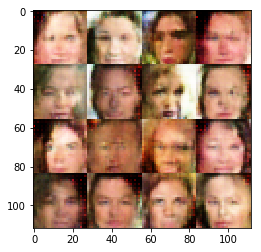

Epoch 1/1... Discriminator Loss: 1.1450 ... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.1062 ... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4080 ... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.4498 ... Generator Loss: 1.6101
Epoch 1/1... Discriminator Loss: 1.2181 ... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3330 ... Generator Loss: 0.5789
Epoch 1/1... Discriminator Loss: 1.3370 ... Generator Loss: 0.5750
Epoch 1/1... Discriminator Loss: 1.2726 ... Generator Loss: 0.9578
Epoch 1/1... Discriminator Loss: 1.4347 ... Generator Loss: 0.5495
Epoch 1/1... Discriminator Loss: 1.4575 ... Generator Loss: 0.6395


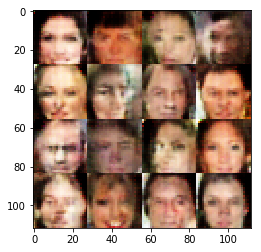

Epoch 1/1... Discriminator Loss: 1.2986 ... Generator Loss: 0.6091
Epoch 1/1... Discriminator Loss: 1.3479 ... Generator Loss: 0.6107
Epoch 1/1... Discriminator Loss: 1.2463 ... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.2904 ... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 1.2637 ... Generator Loss: 0.8024
Epoch 1/1... Discriminator Loss: 1.4380 ... Generator Loss: 1.2650
Epoch 1/1... Discriminator Loss: 1.2547 ... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.3727 ... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.2741 ... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.3329 ... Generator Loss: 0.5761


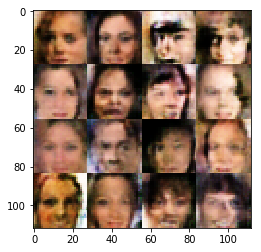

Epoch 1/1... Discriminator Loss: 1.3398 ... Generator Loss: 2.1828
Epoch 1/1... Discriminator Loss: 1.3223 ... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.1531 ... Generator Loss: 1.1844
Epoch 1/1... Discriminator Loss: 1.3934 ... Generator Loss: 0.5834
Epoch 1/1... Discriminator Loss: 1.2776 ... Generator Loss: 0.9061
Epoch 1/1... Discriminator Loss: 1.6414 ... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 1.2817 ... Generator Loss: 0.7279
Epoch 1/1... Discriminator Loss: 1.1291 ... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.5944 ... Generator Loss: 0.5660
Epoch 1/1... Discriminator Loss: 1.2350 ... Generator Loss: 0.7190


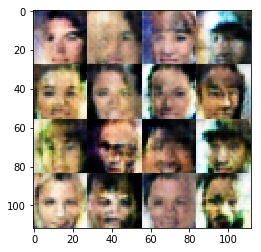

Epoch 1/1... Discriminator Loss: 1.2726 ... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.3194 ... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 0.8739 ... Generator Loss: 1.0931
Epoch 1/1... Discriminator Loss: 1.7944 ... Generator Loss: 0.2944
Epoch 1/1... Discriminator Loss: 1.3428 ... Generator Loss: 0.6408
Epoch 1/1... Discriminator Loss: 1.3816 ... Generator Loss: 0.9137
Epoch 1/1... Discriminator Loss: 1.3544 ... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4439 ... Generator Loss: 0.5283
Epoch 1/1... Discriminator Loss: 1.1306 ... Generator Loss: 0.8566
Epoch 1/1... Discriminator Loss: 1.3949 ... Generator Loss: 0.5037


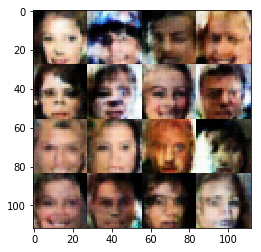

Epoch 1/1... Discriminator Loss: 1.2868 ... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.6225 ... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.4691 ... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.2020 ... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.3301 ... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.3735 ... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.3452 ... Generator Loss: 0.8458
Epoch 1/1... Discriminator Loss: 1.5482 ... Generator Loss: 1.2422
Epoch 1/1... Discriminator Loss: 1.3680 ... Generator Loss: 0.9504
Epoch 1/1... Discriminator Loss: 1.1840 ... Generator Loss: 1.1201


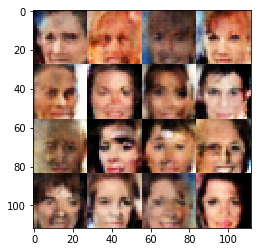

Epoch 1/1... Discriminator Loss: 1.2587 ... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.3645 ... Generator Loss: 1.2566
Epoch 1/1... Discriminator Loss: 1.2298 ... Generator Loss: 0.7305
Epoch 1/1... Discriminator Loss: 1.0002 ... Generator Loss: 1.9193
Epoch 1/1... Discriminator Loss: 1.3073 ... Generator Loss: 0.6013
Epoch 1/1... Discriminator Loss: 1.2752 ... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.3694 ... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.2065 ... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.5646 ... Generator Loss: 0.3796
Epoch 1/1... Discriminator Loss: 1.2086 ... Generator Loss: 1.0050


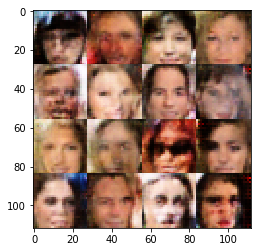

Epoch 1/1... Discriminator Loss: 1.2133 ... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.4031 ... Generator Loss: 0.4790
Epoch 1/1... Discriminator Loss: 1.3088 ... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.2266 ... Generator Loss: 1.0813
Epoch 1/1... Discriminator Loss: 1.2309 ... Generator Loss: 1.2076
Epoch 1/1... Discriminator Loss: 1.4673 ... Generator Loss: 0.4675
Epoch 1/1... Discriminator Loss: 1.1108 ... Generator Loss: 1.2305
Epoch 1/1... Discriminator Loss: 1.1196 ... Generator Loss: 1.9101
Epoch 1/1... Discriminator Loss: 1.4939 ... Generator Loss: 0.5420
Epoch 1/1... Discriminator Loss: 1.3854 ... Generator Loss: 1.2114


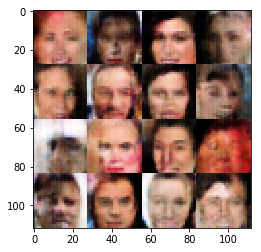

Epoch 1/1... Discriminator Loss: 1.2265 ... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.5056 ... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.3030 ... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.5404 ... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.3249 ... Generator Loss: 0.6658
Epoch 1/1... Discriminator Loss: 1.0597 ... Generator Loss: 1.2091
Epoch 1/1... Discriminator Loss: 1.5854 ... Generator Loss: 0.3808
Epoch 1/1... Discriminator Loss: 1.8776 ... Generator Loss: 0.4245
Epoch 1/1... Discriminator Loss: 1.3493 ... Generator Loss: 0.5864
Epoch 1/1... Discriminator Loss: 1.3723 ... Generator Loss: 0.9754


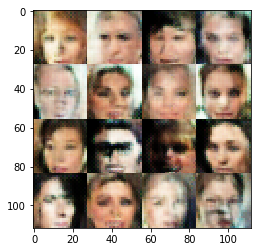

Epoch 1/1... Discriminator Loss: 1.3085 ... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.0192 ... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 1.1132 ... Generator Loss: 1.0495
Epoch 1/1... Discriminator Loss: 1.4179 ... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.1955 ... Generator Loss: 0.8897
Epoch 1/1... Discriminator Loss: 1.4180 ... Generator Loss: 0.5688
Epoch 1/1... Discriminator Loss: 1.1801 ... Generator Loss: 1.3589
Epoch 1/1... Discriminator Loss: 1.4555 ... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.6189 ... Generator Loss: 0.4036
Epoch 1/1... Discriminator Loss: 1.1994 ... Generator Loss: 1.1087


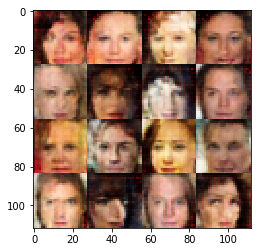

Epoch 1/1... Discriminator Loss: 1.0292 ... Generator Loss: 1.1478
Epoch 1/1... Discriminator Loss: 1.0682 ... Generator Loss: 0.9920
Epoch 1/1... Discriminator Loss: 0.8519 ... Generator Loss: 2.1958
Epoch 1/1... Discriminator Loss: 1.0499 ... Generator Loss: 1.5293
Epoch 1/1... Discriminator Loss: 1.2946 ... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 0.9728 ... Generator Loss: 1.1130
Epoch 1/1... Discriminator Loss: 2.1805 ... Generator Loss: 2.4115
Epoch 1/1... Discriminator Loss: 1.1377 ... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.2733 ... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.0955 ... Generator Loss: 0.9668


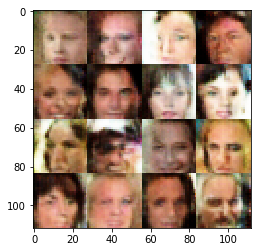

Epoch 1/1... Discriminator Loss: 1.3725 ... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3178 ... Generator Loss: 0.7374
Epoch 1/1... Discriminator Loss: 1.4172 ... Generator Loss: 0.4527
Epoch 1/1... Discriminator Loss: 1.6100 ... Generator Loss: 0.5588
Epoch 1/1... Discriminator Loss: 1.4593 ... Generator Loss: 0.6667
Epoch 1/1... Discriminator Loss: 1.3059 ... Generator Loss: 1.0654
Epoch 1/1... Discriminator Loss: 1.4602 ... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.5244 ... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.0882 ... Generator Loss: 0.9081
Epoch 1/1... Discriminator Loss: 1.3525 ... Generator Loss: 0.6619


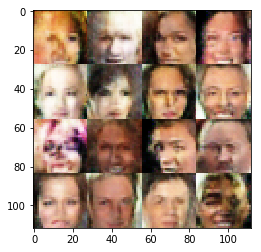

Epoch 1/1... Discriminator Loss: 1.3942 ... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.3620 ... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.1700 ... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.3373 ... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 0.9892 ... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.3552 ... Generator Loss: 0.9263
Epoch 1/1... Discriminator Loss: 1.5308 ... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 1.1197 ... Generator Loss: 0.9205
Epoch 1/1... Discriminator Loss: 0.9455 ... Generator Loss: 1.0310
Epoch 1/1... Discriminator Loss: 0.9520 ... Generator Loss: 1.4239


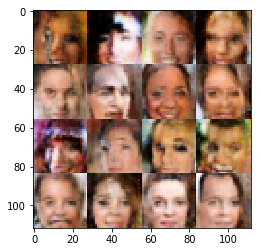

Epoch 1/1... Discriminator Loss: 1.2429 ... Generator Loss: 0.6694
Epoch 1/1... Discriminator Loss: 1.2813 ... Generator Loss: 1.0741
Epoch 1/1... Discriminator Loss: 1.2629 ... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 1.3088 ... Generator Loss: 0.5780
Epoch 1/1... Discriminator Loss: 1.4830 ... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.5705 ... Generator Loss: 0.4189
Epoch 1/1... Discriminator Loss: 1.3674 ... Generator Loss: 1.0203
Epoch 1/1... Discriminator Loss: 1.3493 ... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.6032 ... Generator Loss: 0.4448
Epoch 1/1... Discriminator Loss: 1.4353 ... Generator Loss: 0.5259


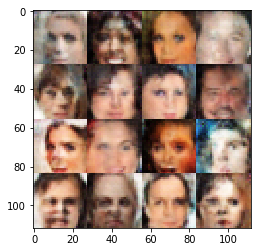

Epoch 1/1... Discriminator Loss: 1.2672 ... Generator Loss: 0.6965
Epoch 1/1... Discriminator Loss: 1.7059 ... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.0295 ... Generator Loss: 0.8275
Epoch 1/1... Discriminator Loss: 1.4210 ... Generator Loss: 0.4905
Epoch 1/1... Discriminator Loss: 1.4134 ... Generator Loss: 0.6843
Epoch 1/1... Discriminator Loss: 1.5337 ... Generator Loss: 1.6162
Epoch 1/1... Discriminator Loss: 1.0148 ... Generator Loss: 1.0913
Epoch 1/1... Discriminator Loss: 1.5957 ... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 1.2164 ... Generator Loss: 0.6334
Epoch 1/1... Discriminator Loss: 1.2351 ... Generator Loss: 0.6649


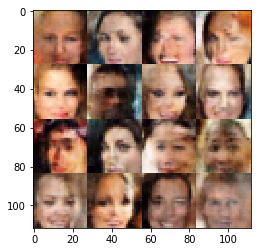

Epoch 1/1... Discriminator Loss: 1.1840 ... Generator Loss: 0.9161
Epoch 1/1... Discriminator Loss: 1.1962 ... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.3283 ... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 0.9229 ... Generator Loss: 1.1605
Epoch 1/1... Discriminator Loss: 1.7830 ... Generator Loss: 0.3182
Epoch 1/1... Discriminator Loss: 1.6167 ... Generator Loss: 0.4122
Epoch 1/1... Discriminator Loss: 1.4132 ... Generator Loss: 1.1228
Epoch 1/1... Discriminator Loss: 1.3341 ... Generator Loss: 1.5290
Epoch 1/1... Discriminator Loss: 1.5521 ... Generator Loss: 0.4972
Epoch 1/1... Discriminator Loss: 1.4409 ... Generator Loss: 0.7671


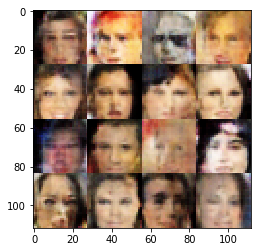

Epoch 1/1... Discriminator Loss: 1.3750 ... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.1472 ... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.2765 ... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.5527 ... Generator Loss: 0.5936
Epoch 1/1... Discriminator Loss: 1.4654 ... Generator Loss: 0.5634
Epoch 1/1... Discriminator Loss: 1.5324 ... Generator Loss: 0.4156
Epoch 1/1... Discriminator Loss: 1.3149 ... Generator Loss: 0.7510
Epoch 1/1... Discriminator Loss: 1.0862 ... Generator Loss: 1.1743
Epoch 1/1... Discriminator Loss: 0.9801 ... Generator Loss: 1.4587
Epoch 1/1... Discriminator Loss: 1.3340 ... Generator Loss: 0.6546


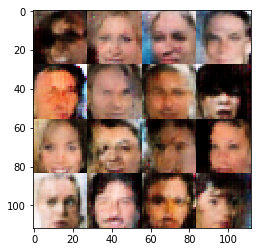

Epoch 1/1... Discriminator Loss: 1.6693 ... Generator Loss: 0.3734
Epoch 1/1... Discriminator Loss: 1.5709 ... Generator Loss: 0.9204
Epoch 1/1... Discriminator Loss: 1.4696 ... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.3311 ... Generator Loss: 0.6604
Epoch 1/1... Discriminator Loss: 1.3387 ... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.0751 ... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.2174 ... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 0.7967 ... Generator Loss: 2.1249
Epoch 1/1... Discriminator Loss: 1.2252 ... Generator Loss: 0.9656
Epoch 1/1... Discriminator Loss: 1.6274 ... Generator Loss: 0.3634


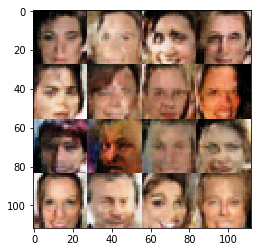

Epoch 1/1... Discriminator Loss: 0.8288 ... Generator Loss: 1.5747
Epoch 1/1... Discriminator Loss: 1.2765 ... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.3136 ... Generator Loss: 0.6185
Epoch 1/1... Discriminator Loss: 1.1818 ... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.6677 ... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.3238 ... Generator Loss: 0.8249
Epoch 1/1... Discriminator Loss: 1.0653 ... Generator Loss: 1.1808
Epoch 1/1... Discriminator Loss: 1.3549 ... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.3598 ... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.3061 ... Generator Loss: 1.6862


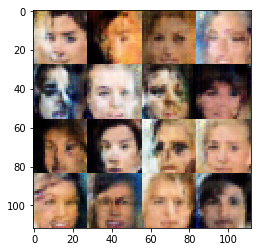

Epoch 1/1... Discriminator Loss: 1.2546 ... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.0062 ... Generator Loss: 1.1760
Epoch 1/1... Discriminator Loss: 1.3819 ... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.4362 ... Generator Loss: 0.5071
Epoch 1/1... Discriminator Loss: 1.4901 ... Generator Loss: 0.4901
Epoch 1/1... Discriminator Loss: 1.3623 ... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2909 ... Generator Loss: 0.6611
Epoch 1/1... Discriminator Loss: 1.5430 ... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.4336 ... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.4725 ... Generator Loss: 0.4898


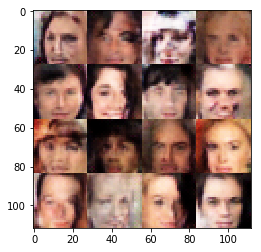

Epoch 1/1... Discriminator Loss: 1.4007 ... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.5411 ... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 1.3635 ... Generator Loss: 0.8850
Epoch 1/1... Discriminator Loss: 1.5083 ... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 0.7483 ... Generator Loss: 1.5421
Epoch 1/1... Discriminator Loss: 1.5157 ... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.4350 ... Generator Loss: 0.5766
Epoch 1/1... Discriminator Loss: 1.2477 ... Generator Loss: 1.2342
Epoch 1/1... Discriminator Loss: 1.6167 ... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 1.3336 ... Generator Loss: 0.7784


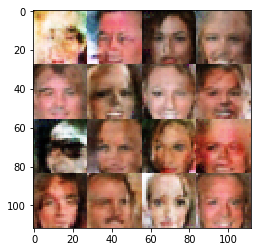

Epoch 1/1... Discriminator Loss: 1.3177 ... Generator Loss: 1.2032
Epoch 1/1... Discriminator Loss: 1.3930 ... Generator Loss: 0.6586
Epoch 1/1... Discriminator Loss: 1.1572 ... Generator Loss: 1.0119
Epoch 1/1... Discriminator Loss: 1.2924 ... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.2834 ... Generator Loss: 0.9238
Epoch 1/1... Discriminator Loss: 1.2531 ... Generator Loss: 1.0120
Epoch 1/1... Discriminator Loss: 1.4187 ... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.3230 ... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.2767 ... Generator Loss: 0.7515
Epoch 1/1... Discriminator Loss: 1.3971 ... Generator Loss: 0.7578


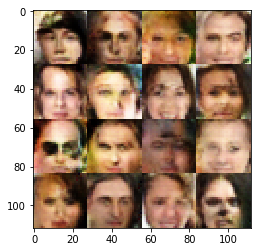

Epoch 1/1... Discriminator Loss: 1.4565 ... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.2657 ... Generator Loss: 0.9615
Epoch 1/1... Discriminator Loss: 1.1249 ... Generator Loss: 1.0152
Epoch 1/1... Discriminator Loss: 1.2282 ... Generator Loss: 0.7169
Epoch 1/1... Discriminator Loss: 1.3620 ... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.3105 ... Generator Loss: 0.6582
Epoch 1/1... Discriminator Loss: 1.4642 ... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.5209 ... Generator Loss: 0.5025
Epoch 1/1... Discriminator Loss: 0.9791 ... Generator Loss: 1.2658
Epoch 1/1... Discriminator Loss: 1.1911 ... Generator Loss: 0.8445


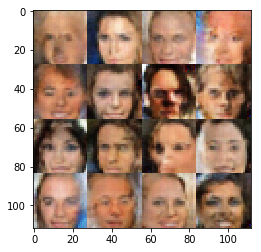

Epoch 1/1... Discriminator Loss: 1.4916 ... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 1.1808 ... Generator Loss: 0.8565
Epoch 1/1... Discriminator Loss: 1.4003 ... Generator Loss: 0.7351
Epoch 1/1... Discriminator Loss: 1.4157 ... Generator Loss: 0.7309
Epoch 1/1... Discriminator Loss: 1.6142 ... Generator Loss: 0.5043
Epoch 1/1... Discriminator Loss: 1.4699 ... Generator Loss: 0.5987
Epoch 1/1... Discriminator Loss: 1.4431 ... Generator Loss: 0.6372
Epoch 1/1... Discriminator Loss: 1.3916 ... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3128 ... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.5086 ... Generator Loss: 0.4871


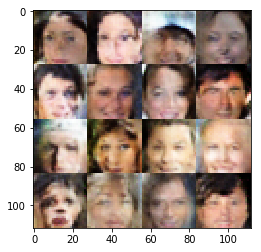

Epoch 1/1... Discriminator Loss: 1.3314 ... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.5283 ... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.2389 ... Generator Loss: 0.8210
Epoch 1/1... Discriminator Loss: 1.4550 ... Generator Loss: 0.7453
Epoch 1/1... Discriminator Loss: 1.5643 ... Generator Loss: 0.4571
Epoch 1/1... Discriminator Loss: 1.4690 ... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.4106 ... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.3533 ... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.4152 ... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.4114 ... Generator Loss: 0.5831


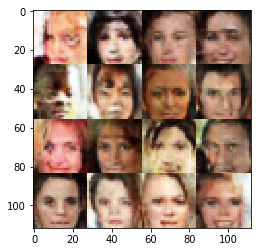

Epoch 1/1... Discriminator Loss: 1.2792 ... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.3496 ... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.4374 ... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.1442 ... Generator Loss: 0.9564
Epoch 1/1... Discriminator Loss: 1.4518 ... Generator Loss: 0.5986
Epoch 1/1... Discriminator Loss: 1.1116 ... Generator Loss: 1.0430
Epoch 1/1... Discriminator Loss: 1.3236 ... Generator Loss: 0.6161
Epoch 1/1... Discriminator Loss: 1.4333 ... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.3583 ... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.3924 ... Generator Loss: 0.7821


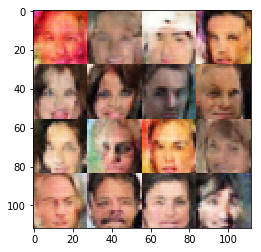

Epoch 1/1... Discriminator Loss: 1.1401 ... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2928 ... Generator Loss: 0.8734
Epoch 1/1... Discriminator Loss: 1.2699 ... Generator Loss: 0.9025
Epoch 1/1... Discriminator Loss: 1.8685 ... Generator Loss: 0.3615
Epoch 1/1... Discriminator Loss: 1.3804 ... Generator Loss: 0.7071
Epoch 1/1... Discriminator Loss: 1.4935 ... Generator Loss: 0.5749
Epoch 1/1... Discriminator Loss: 1.2434 ... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.2515 ... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3326 ... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.3244 ... Generator Loss: 0.5995


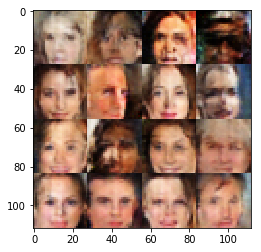

Epoch 1/1... Discriminator Loss: 1.3778 ... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.2759 ... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.2988 ... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.6259 ... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 1.3931 ... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.5328 ... Generator Loss: 0.4960
Epoch 1/1... Discriminator Loss: 1.3720 ... Generator Loss: 0.7096
Epoch 1/1... Discriminator Loss: 1.3309 ... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.2239 ... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.4419 ... Generator Loss: 0.5855


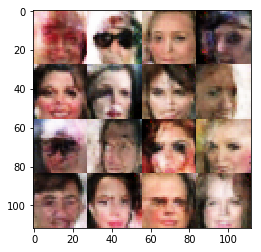

Epoch 1/1... Discriminator Loss: 1.3424 ... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.2103 ... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4906 ... Generator Loss: 0.5709
Epoch 1/1... Discriminator Loss: 1.4265 ... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.4133 ... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.4051 ... Generator Loss: 0.6880
Epoch 1/1... Discriminator Loss: 1.3495 ... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3466 ... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.5286 ... Generator Loss: 0.4697
Epoch 1/1... Discriminator Loss: 1.3561 ... Generator Loss: 0.6790


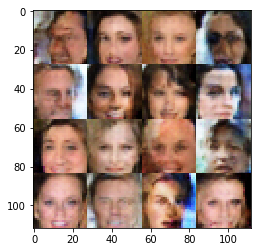

Epoch 1/1... Discriminator Loss: 1.3569 ... Generator Loss: 0.6507
Epoch 1/1... Discriminator Loss: 1.4745 ... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.2467 ... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4738 ... Generator Loss: 0.5914
Epoch 1/1... Discriminator Loss: 1.2133 ... Generator Loss: 0.9051
Epoch 1/1... Discriminator Loss: 1.4840 ... Generator Loss: 0.6139
Epoch 1/1... Discriminator Loss: 1.6412 ... Generator Loss: 0.4494
Epoch 1/1... Discriminator Loss: 1.3320 ... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.2969 ... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.3290 ... Generator Loss: 0.6902


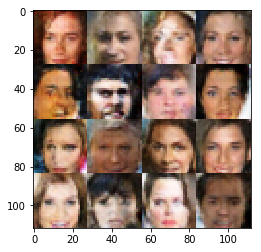

Epoch 1/1... Discriminator Loss: 1.1480 ... Generator Loss: 0.8523
Epoch 1/1... Discriminator Loss: 1.4998 ... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.2483 ... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.4387 ... Generator Loss: 0.6266
Epoch 1/1... Discriminator Loss: 1.2467 ... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.1433 ... Generator Loss: 1.1021
Epoch 1/1... Discriminator Loss: 1.2849 ... Generator Loss: 0.7728
Epoch 1/1... Discriminator Loss: 1.4409 ... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.1971 ... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.2979 ... Generator Loss: 0.5634


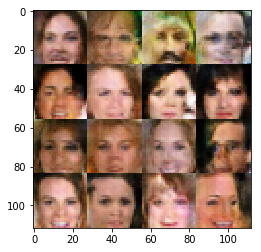

Epoch 1/1... Discriminator Loss: 1.4955 ... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 1.3304 ... Generator Loss: 0.7246
Epoch 1/1... Discriminator Loss: 1.3772 ... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.4630 ... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.3490 ... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.1148 ... Generator Loss: 1.0129
Epoch 1/1... Discriminator Loss: 1.4400 ... Generator Loss: 0.6333
Epoch 1/1... Discriminator Loss: 1.4331 ... Generator Loss: 0.7202
Epoch 1/1... Discriminator Loss: 1.4511 ... Generator Loss: 0.8774
Epoch 1/1... Discriminator Loss: 1.2739 ... Generator Loss: 0.7003


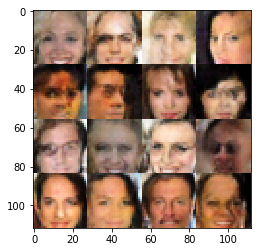

Epoch 1/1... Discriminator Loss: 1.4275 ... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.3867 ... Generator Loss: 0.7113
Epoch 1/1... Discriminator Loss: 1.5366 ... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4204 ... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.2806 ... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3305 ... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2490 ... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.4039 ... Generator Loss: 0.7043
Epoch 1/1... Discriminator Loss: 1.3779 ... Generator Loss: 0.6689
Epoch 1/1... Discriminator Loss: 1.5263 ... Generator Loss: 0.5195


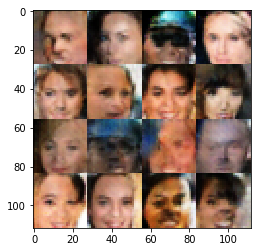

Epoch 1/1... Discriminator Loss: 1.5752 ... Generator Loss: 0.9428
Epoch 1/1... Discriminator Loss: 1.3428 ... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4164 ... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.4015 ... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.2609 ... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.7354 ... Generator Loss: 0.4512
Epoch 1/1... Discriminator Loss: 1.1730 ... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 1.3950 ... Generator Loss: 1.0337
Epoch 1/1... Discriminator Loss: 1.3617 ... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.3687 ... Generator Loss: 0.6806


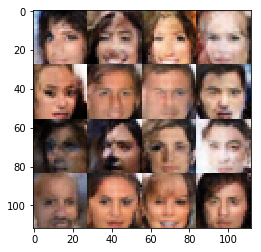

Epoch 1/1... Discriminator Loss: 1.4053 ... Generator Loss: 0.6797
Epoch 1/1... Discriminator Loss: 1.3523 ... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4065 ... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.2693 ... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.2775 ... Generator Loss: 0.6865
Epoch 1/1... Discriminator Loss: 1.3815 ... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3547 ... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4379 ... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4487 ... Generator Loss: 0.6115
Epoch 1/1... Discriminator Loss: 1.5047 ... Generator Loss: 0.5037


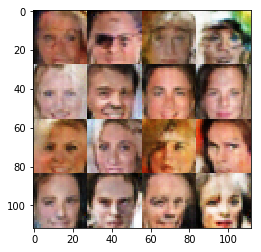

Epoch 1/1... Discriminator Loss: 1.3280 ... Generator Loss: 0.7841
Epoch 1/1... Discriminator Loss: 1.3528 ... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.4149 ... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.3794 ... Generator Loss: 0.5717
Epoch 1/1... Discriminator Loss: 1.4877 ... Generator Loss: 0.5388
Epoch 1/1... Discriminator Loss: 1.3712 ... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.5197 ... Generator Loss: 0.5643
Epoch 1/1... Discriminator Loss: 1.3633 ... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.5317 ... Generator Loss: 0.6178
Epoch 1/1... Discriminator Loss: 1.3797 ... Generator Loss: 0.6852


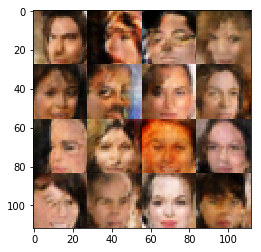

Epoch 1/1... Discriminator Loss: 1.4635 ... Generator Loss: 0.5506
Epoch 1/1... Discriminator Loss: 1.4252 ... Generator Loss: 0.7033
Epoch 1/1... Discriminator Loss: 1.2904 ... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3472 ... Generator Loss: 0.6404
Epoch 1/1... Discriminator Loss: 1.4644 ... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5333 ... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 1.0899 ... Generator Loss: 0.8306
Epoch 1/1... Discriminator Loss: 1.4376 ... Generator Loss: 0.6328
Epoch 1/1... Discriminator Loss: 1.4974 ... Generator Loss: 0.6225
Epoch 1/1... Discriminator Loss: 1.3460 ... Generator Loss: 0.6823


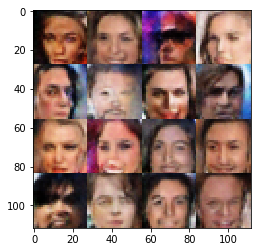

Epoch 1/1... Discriminator Loss: 1.3086 ... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.3947 ... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.4889 ... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 1.3865 ... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.2581 ... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3201 ... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3309 ... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.1900 ... Generator Loss: 0.7593
Epoch 1/1... Discriminator Loss: 1.2518 ... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4368 ... Generator Loss: 0.5175


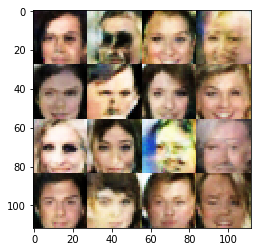

Epoch 1/1... Discriminator Loss: 1.3254 ... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3298 ... Generator Loss: 0.8762
Epoch 1/1... Discriminator Loss: 1.3901 ... Generator Loss: 0.5356
Epoch 1/1... Discriminator Loss: 1.4251 ... Generator Loss: 0.7907
Epoch 1/1... Discriminator Loss: 1.2396 ... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4163 ... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.3463 ... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4153 ... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.4451 ... Generator Loss: 0.5670
Epoch 1/1... Discriminator Loss: 1.3784 ... Generator Loss: 0.7294


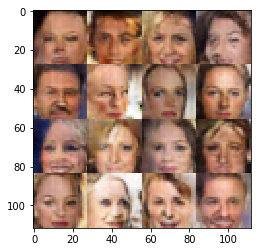

Epoch 1/1... Discriminator Loss: 1.3805 ... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.4371 ... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4242 ... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.3459 ... Generator Loss: 0.6958
Epoch 1/1... Discriminator Loss: 1.3693 ... Generator Loss: 0.7038
Epoch 1/1... Discriminator Loss: 1.2730 ... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.3678 ... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.2077 ... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3405 ... Generator Loss: 0.6608
Epoch 1/1... Discriminator Loss: 1.3472 ... Generator Loss: 0.6740


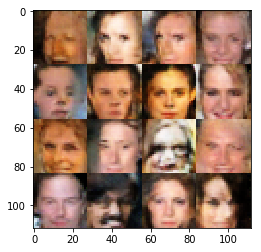

Epoch 1/1... Discriminator Loss: 1.4246 ... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.3289 ... Generator Loss: 0.8090
Epoch 1/1... Discriminator Loss: 1.3108 ... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.3255 ... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.4297 ... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 1.4737 ... Generator Loss: 0.5946
Epoch 1/1... Discriminator Loss: 1.2540 ... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.2422 ... Generator Loss: 0.8494
Epoch 1/1... Discriminator Loss: 1.2560 ... Generator Loss: 0.7181
Epoch 1/1... Discriminator Loss: 1.4320 ... Generator Loss: 0.5458


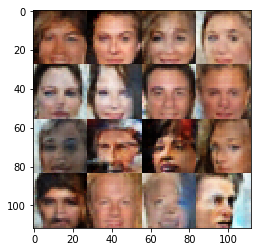

Epoch 1/1... Discriminator Loss: 1.3425 ... Generator Loss: 0.7076
Epoch 1/1... Discriminator Loss: 1.4947 ... Generator Loss: 0.5327
Epoch 1/1... Discriminator Loss: 1.4470 ... Generator Loss: 0.5332
Epoch 1/1... Discriminator Loss: 1.4311 ... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4753 ... Generator Loss: 0.6276
Epoch 1/1... Discriminator Loss: 1.3279 ... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.3933 ... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.3297 ... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.4441 ... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3153 ... Generator Loss: 0.8247


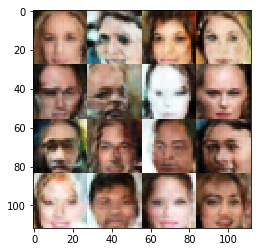

Epoch 1/1... Discriminator Loss: 1.4984 ... Generator Loss: 0.5909
Epoch 1/1... Discriminator Loss: 1.4130 ... Generator Loss: 0.5710
Epoch 1/1... Discriminator Loss: 1.3549 ... Generator Loss: 0.7026
Epoch 1/1... Discriminator Loss: 1.4507 ... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.3314 ... Generator Loss: 0.7243
Epoch 1/1... Discriminator Loss: 1.3598 ... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.2630 ... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.4229 ... Generator Loss: 0.6409
Epoch 1/1... Discriminator Loss: 1.5437 ... Generator Loss: 0.6195
Epoch 1/1... Discriminator Loss: 1.3624 ... Generator Loss: 0.7512


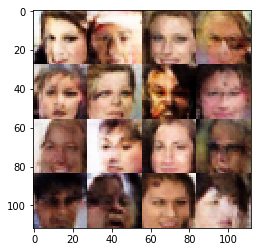

Epoch 1/1... Discriminator Loss: 1.5136 ... Generator Loss: 0.5157
Epoch 1/1... Discriminator Loss: 1.3463 ... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.5703 ... Generator Loss: 0.4963
Epoch 1/1... Discriminator Loss: 1.4610 ... Generator Loss: 0.5797
Epoch 1/1... Discriminator Loss: 1.3912 ... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.4291 ... Generator Loss: 0.7105
Epoch 1/1... Discriminator Loss: 1.4203 ... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.3913 ... Generator Loss: 0.7584
Epoch 1/1... Discriminator Loss: 1.4240 ... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3114 ... Generator Loss: 0.8471


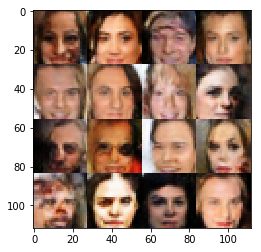

Epoch 1/1... Discriminator Loss: 1.3559 ... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.3429 ... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4791 ... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.2882 ... Generator Loss: 0.8946
Epoch 1/1... Discriminator Loss: 1.3151 ... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3606 ... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.2309 ... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.5103 ... Generator Loss: 0.6075
Epoch 1/1... Discriminator Loss: 1.4155 ... Generator Loss: 0.6543
Epoch 1/1... Discriminator Loss: 1.3620 ... Generator Loss: 0.7821


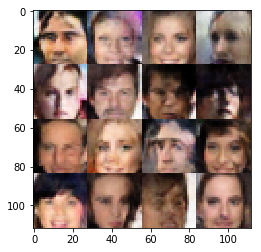

Epoch 1/1... Discriminator Loss: 1.4263 ... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3567 ... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.2930 ... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4062 ... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.4503 ... Generator Loss: 0.6660
Epoch 1/1... Discriminator Loss: 1.4620 ... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.2338 ... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.4948 ... Generator Loss: 0.6132
Epoch 1/1... Discriminator Loss: 1.3074 ... Generator Loss: 0.9414
Epoch 1/1... Discriminator Loss: 1.3782 ... Generator Loss: 0.7307


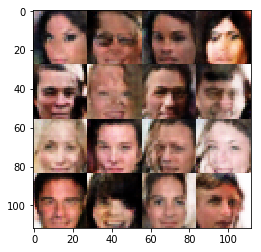

Epoch 1/1... Discriminator Loss: 1.4896 ... Generator Loss: 0.5889
Epoch 1/1... Discriminator Loss: 1.2770 ... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.4136 ... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4440 ... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.4283 ... Generator Loss: 0.5633
Epoch 1/1... Discriminator Loss: 1.3755 ... Generator Loss: 0.7342
Epoch 1/1... Discriminator Loss: 1.6078 ... Generator Loss: 0.5344
Epoch 1/1... Discriminator Loss: 1.4884 ... Generator Loss: 0.5250
Epoch 1/1... Discriminator Loss: 1.4583 ... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.3317 ... Generator Loss: 0.7344


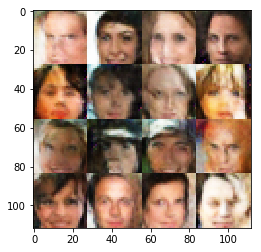

Epoch 1/1... Discriminator Loss: 1.3727 ... Generator Loss: 0.6656
Epoch 1/1... Discriminator Loss: 1.3522 ... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.3270 ... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.5171 ... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.6010 ... Generator Loss: 0.4802
Epoch 1/1... Discriminator Loss: 1.4172 ... Generator Loss: 0.6740
Epoch 1/1... Discriminator Loss: 1.1455 ... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.3659 ... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.2806 ... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.1904 ... Generator Loss: 0.8196


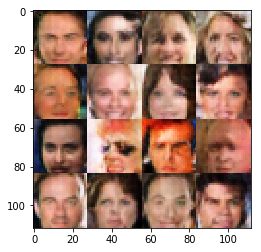

Epoch 1/1... Discriminator Loss: 1.5294 ... Generator Loss: 0.4495
Epoch 1/1... Discriminator Loss: 1.4509 ... Generator Loss: 0.5415
Epoch 1/1... Discriminator Loss: 1.3863 ... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.4449 ... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4184 ... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 0.7905 ... Generator Loss: 1.5992
Epoch 1/1... Discriminator Loss: 1.4806 ... Generator Loss: 0.4659
Epoch 1/1... Discriminator Loss: 1.4529 ... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.5187 ... Generator Loss: 0.5807
Epoch 1/1... Discriminator Loss: 1.2943 ... Generator Loss: 0.8296


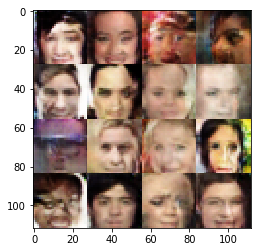

Epoch 1/1... Discriminator Loss: 1.3795 ... Generator Loss: 0.6832
Epoch 1/1... Discriminator Loss: 1.3549 ... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4653 ... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.3530 ... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.3766 ... Generator Loss: 0.6190
Epoch 1/1... Discriminator Loss: 1.3624 ... Generator Loss: 0.6824
Epoch 1/1... Discriminator Loss: 1.3650 ... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3433 ... Generator Loss: 0.7621
Epoch 1/1... Discriminator Loss: 1.3028 ... Generator Loss: 0.7410
Epoch 1/1... Discriminator Loss: 1.4716 ... Generator Loss: 0.5983


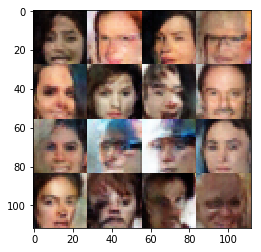

Epoch 1/1... Discriminator Loss: 1.2905 ... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3277 ... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.4480 ... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.2034 ... Generator Loss: 0.8516
Epoch 1/1... Discriminator Loss: 1.4963 ... Generator Loss: 0.6534
Epoch 1/1... Discriminator Loss: 1.3503 ... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.2736 ... Generator Loss: 0.8728
Epoch 1/1... Discriminator Loss: 1.3366 ... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.3852 ... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.3696 ... Generator Loss: 0.7657


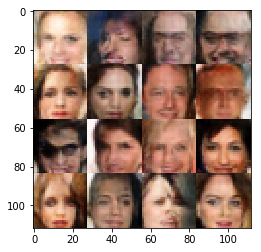

Epoch 1/1... Discriminator Loss: 1.4062 ... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.3147 ... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.2092 ... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.6208 ... Generator Loss: 0.5030
Epoch 1/1... Discriminator Loss: 1.5023 ... Generator Loss: 0.5502
Epoch 1/1... Discriminator Loss: 1.4292 ... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3223 ... Generator Loss: 0.7319
Epoch 1/1... Discriminator Loss: 1.3824 ... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.5209 ... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.4501 ... Generator Loss: 0.6541


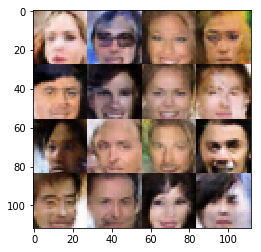

Epoch 1/1... Discriminator Loss: 1.4030 ... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.3469 ... Generator Loss: 0.7489
Epoch 1/1... Discriminator Loss: 1.3858 ... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.4107 ... Generator Loss: 0.5928
Epoch 1/1... Discriminator Loss: 1.4257 ... Generator Loss: 0.6645
Epoch 1/1... Discriminator Loss: 1.3858 ... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4631 ... Generator Loss: 0.6480
Epoch 1/1... Discriminator Loss: 1.5196 ... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.3933 ... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.5679 ... Generator Loss: 0.6092


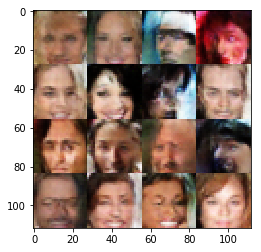

Epoch 1/1... Discriminator Loss: 1.3051 ... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.3922 ... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 1.2830 ... Generator Loss: 0.8564
Epoch 1/1... Discriminator Loss: 1.4252 ... Generator Loss: 0.7331
Epoch 1/1... Discriminator Loss: 1.3496 ... Generator Loss: 0.7943
Epoch 1/1... Discriminator Loss: 1.4385 ... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.5912 ... Generator Loss: 0.6556
Epoch 1/1... Discriminator Loss: 1.3711 ... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3547 ... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.4843 ... Generator Loss: 0.6984


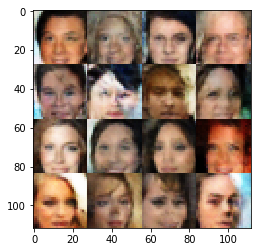

Epoch 1/1... Discriminator Loss: 1.5440 ... Generator Loss: 0.4885
Epoch 1/1... Discriminator Loss: 1.4574 ... Generator Loss: 0.5942
Epoch 1/1... Discriminator Loss: 1.3757 ... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.3197 ... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.3813 ... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.3018 ... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.2458 ... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.2124 ... Generator Loss: 0.8307
Epoch 1/1... Discriminator Loss: 1.3358 ... Generator Loss: 0.7686
Epoch 1/1... Discriminator Loss: 1.3874 ... Generator Loss: 0.7549


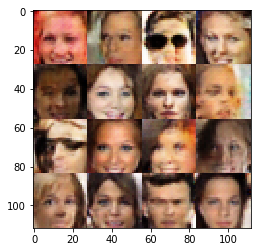

Epoch 1/1... Discriminator Loss: 1.1171 ... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.5016 ... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.3760 ... Generator Loss: 0.6759
Finished


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0006
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.